# Machine Learning Engineer Nanodegree

## Capstone Project
---
Nobuyoshi Shimmen     
May 27th, 2017

## I. Definition

### Project Overview  

There are mainly two ways to evaluate stock market: technical analysis and fundamental analysis. Technical analysis assumes that a stock price reflects all the information that decides the price available to public and predicts how a stock moves by statically looking at the history of the price movements. Fundamental analysis, on the other hand, tries to see through intrinsic value of a company by analyzing corporate financial statements, like balance sheet and income statement. 
    
They are used to see if a stock is undervalued or not. Technical analysis is said to be effective for predicting short-term trading trends because there is less uncertain elements than in the long term future. Fundamental analysis show its value in long term stock investment because you need time to wait before a company’s true value is recognized in the market.
    
Hedge funds and institutional investors have been focusing on technical analysis because of the nature of the business they are in. In short period of time, they have to leverage their customers’ money and make some profit for the customers. Also they do this for themselves because their salaries are greatly affected by how much profit they make. So they have been putting effort and money into applying machine learning to technical analysis for a long time.
    
Retail investors prefer fundamental analysis to technical analysis, because they simply cannot afford so much transaction cost for buying and selling stocks that technical analysis requires to make capital gains in short period time. Also, fundamental analysis has been proven effective and recommended by many famous investors like Warren Buffet. Interestingly and sadly, however, even though fundamental analysis have been seen as practical and helpful to individual investors, little research hasn’t been done for applying machine learning to fundamental analysis.
    
Therefore, in this project, my focus is on fundamental analysis and I would like to see how machine learning can predict winning stocks in the long run by using fundamentals of companies.  
    
    
### Problem Statement
Fundamental analysis is suited for individual investors by nature but almost no one has tried to apply machine learning to this. My goal is to make a model that can pick winning stocks in the long run and outperform the stock market. In other words, a model would make a portfolio whose growth rate is higher than the market. Also, what I mean by the long run is one year. To be more clearly, I have a model predict the prices of stocks on December 30 or 31st of a year, using corporate fundamentals in December or January of the previous year, and corporate fundamentals are like Net Income, Operating Income, and Earnings Per Share.
    
### Metrics 
In this project, there are two types of evaluations. One is used for evaluating the performance of a model, so that I can choose the best one.  
I used coefficient of determination, which is often called R2. This metric is useful in regression analysis, because it describes how good a model is at making predictions. The maximum score of it is 1 and the minimum score of it is 0 and the greater the r2 score is, the better the model is fitting.

\begin{align}
r^2 = 1 - \frac{\sum_{i=1}^n (y_i−f(x_i))^2}{\sum_{i=1}^n (y_i−\mu_Y)^2}
\end{align}
 
The other metric is for comparing the performance of a model to benchmark. I used compound annual growth rate (CAGR) for this.  
Many stock investors and analysts use GAGR to evaluate the performance of investments. The definition is as follows.

\begin{align}
CAGR = \frac{\text{Ending Value}}{\text{Beginninng Value}}^\frac{1}{\text{number of years}}-1
\end{align}

I had the best model predict prices of all the stocks in one year. Then I calculated the CAGR of 30 stocks that would get the highest growth in price, using the sum of original stock prices as the beginning value and the sum of the next year prices* as the ending value. Finally I compared the result to the CAGR of return on the market.
    
*These are not what are predicted by the model, but are the actual prices of the following year.
    


## II. Analysis

### Data Exploration & Exploratory Visualization

I prepared two kinds of datasets to make a model; one is fundamentals and the other is historical stock prices.  
These are obtained from Kaggle (https://www.kaggle.com/dgawlik/nyse): fundamentals.csv and prices-split-adjusted.csv.  
#### fundamentals.csv(modified-fundamentals.csv)
It contains corporate financial statements of 2012-2015.  
I removed some of the columns based on this book ( https://www.amazon.com/Investing-Dummies-Fifth-Eric-Tyson/dp/B0031569MO
), and change the file name to modified-fundamentals.csv; I selected 14 important items that are used for fundamental analysis. For example, they are like...  
- Ticker Symbol: This is an abbreviation used to identify a particular stock on a stock market  
- Gross Profit: This is the profit a company makes after subtracting the costs associated with making and selling its products/services.     
- Operating Income: This is the profit earned from a company's business operations    
- Research and Development:   
- Earnings Per Share: This is the amount of a company's profit allocated to each share of stock.  
   
#### prices-split-adjusted.csv  
It contains daily prices from 2010 to the end 2016, and the columns are like...  
- symbol: This is an abbreviation used to identify a particular stock on a stock market  
- date: This is a date of each price is set  
- open: This is a price of stock when the marke opens  
- close: This is a price of stock when the marke closes  
  
I only used symol, date, and close columns. To be more specific, I used them on December 30/31 of each year.    
  
  
I used things in modified-fundamentals.csv as features and the stock price of December 31 or 30  of the following year as label.  
For example, when features are the fundamental data of a company in 2012, a label is the close price of the stock on December 31 in 2013.   

In [241]:
# Import  libraries
import pandas as pd
import numpy as np

from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

# Load the dataset of fundamentals
fundamental_data = pd.read_csv('modified-fundamentals.csv')

# Load the dataset of split-adjusted-price
price_data = pd.read_csv('prices-split-adjusted.csv')

print "Examples"
display(fundamental_data.head(n = 1))
display(price_data.head(n = 1))

Examples


,Ticker Symbol,Earnings Before Interest and Tax,Gross Profit,Intangible Assets,Net Income,Operating Income,Pre-Tax ROE,Research and Development,Total Assets,Total Equity,Total Liabilities,Total Revenue,For Year,Earnings Per Share
0,AAL,-1813000000,1.435600e+10,869000000.0,-1876000000,148000000,31,0,2.351000e+10,-7.987000e+09,2.489100e+10,2.485500e+10,2012.0,-5.6


,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.43,125.839996,122.309998,126.25,2163600.0


I explored them as follows. 
1. Get descriptive statistics of features for one random year   
        - Min value, Max value, Mean value, Median value and Standard deviation of values  
        - See if there is any feature that has highly-skewed distribution
2. Get descriptive statistics of labels for one random year  
        - Min value, Max value, Mean value, Median value and Standard deviation of values  

In [1]:
# I found out some of the values are missing while exploring data.
# So I fill in the mean values of each feature except for For Year feature.
fundamental_year_data = fundamental_data['For Year'].fillna("missing")
fundamental_data = fundamental_data.drop(['For Year'], axis=1).fillna(fundamental_data.mean())
fundamental_data = pd.concat([fundamental_data, fundamental_year_data], axis=1)

# Success
print "fundamental dataset has {} data points with {} variables each.".format(*fundamental_data.shape)

price_data = price_data.drop(['open', 'volume', 'low', 'high'], axis=1)

# I use stock close price of December 31st each year as labels.
price_data_31 =price_data[price_data.date.str.contains('12-31') == True]
# For the years 2011 and 2016, the stock market ended on the 30th.
price_data_30 =price_data[price_data.date.str.contains('12-30') == True]

price_data = pd.concat([price_data_31, price_data_30])

# Success
print "split price dataset has {} data points with {} variables each.".format(*price_data.shape)

fundamental dataset has 1781 data points with 14 variables each.
split price dataset has 5339 data points with 3 variables each.


year: 2015


,Earnings Before Interest and Tax,Gross Profit,Intangible Assets,Net Income,Operating Income,Pre-Tax ROE,Research and Development,Total Assets,Total Equity,Total Liabilities,Total Revenue,For Year,Earnings Per Share
count,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,425.000000,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,425.0,412.000000
mean,2.457597e+09,7.384579e+09,2.209566e+09,1.575186e+09,2.116172e+09,54.249412,3.655569e+08,5.368703e+10,1.162822e+10,4.204838e+10,2.016654e+10,2015.0,3.019854
std,6.344137e+09,1.351790e+10,8.175182e+09,4.409270e+09,5.763406e+09,130.080740,1.297193e+09,1.816241e+11,2.503089e+10,1.609421e+11,3.898290e+10,0.0,6.257429
min,-2.792700e+10,-1.264700e+10,0.000000e+00,-2.352800e+10,-2.791000e+10,1.000000,0.000000e+00,1.474993e+09,-1.324400e+10,3.061520e+08,7.440120e+08,2015.0,-61.200000
25%,5.919080e+08,1.658870e+09,0.000000e+00,3.577960e+08,5.245270e+08,13.000000,0.000000e+00,7.278000e+09,2.349300e+09,4.572600e+09,3.956000e+09,2015.0,1.597500
50%,1.128286e+09,3.109281e+09,3.793050e+08,6.929570e+08,1.035000e+09,23.000000,0.000000e+00,1.590120e+10,5.104287e+09,1.013200e+10,8.592000e+09,2015.0,2.935000
75%,2.559000e+09,6.676000e+09,1.687326e+09,1.623600e+09,2.197000e+09,40.000000,6.371800e+07,3.887740e+10,1.061700e+10,2.453190e+10,1.748600e+10,2015.0,4.787500
max,7.251500e+10,1.205650e+11,1.207100e+11,5.339400e+10,7.123000e+10,1100.000000,1.212800e+10,2.351698e+12,2.475730e+11,2.104125e+12,4.856510e+11,2015.0,50.090000


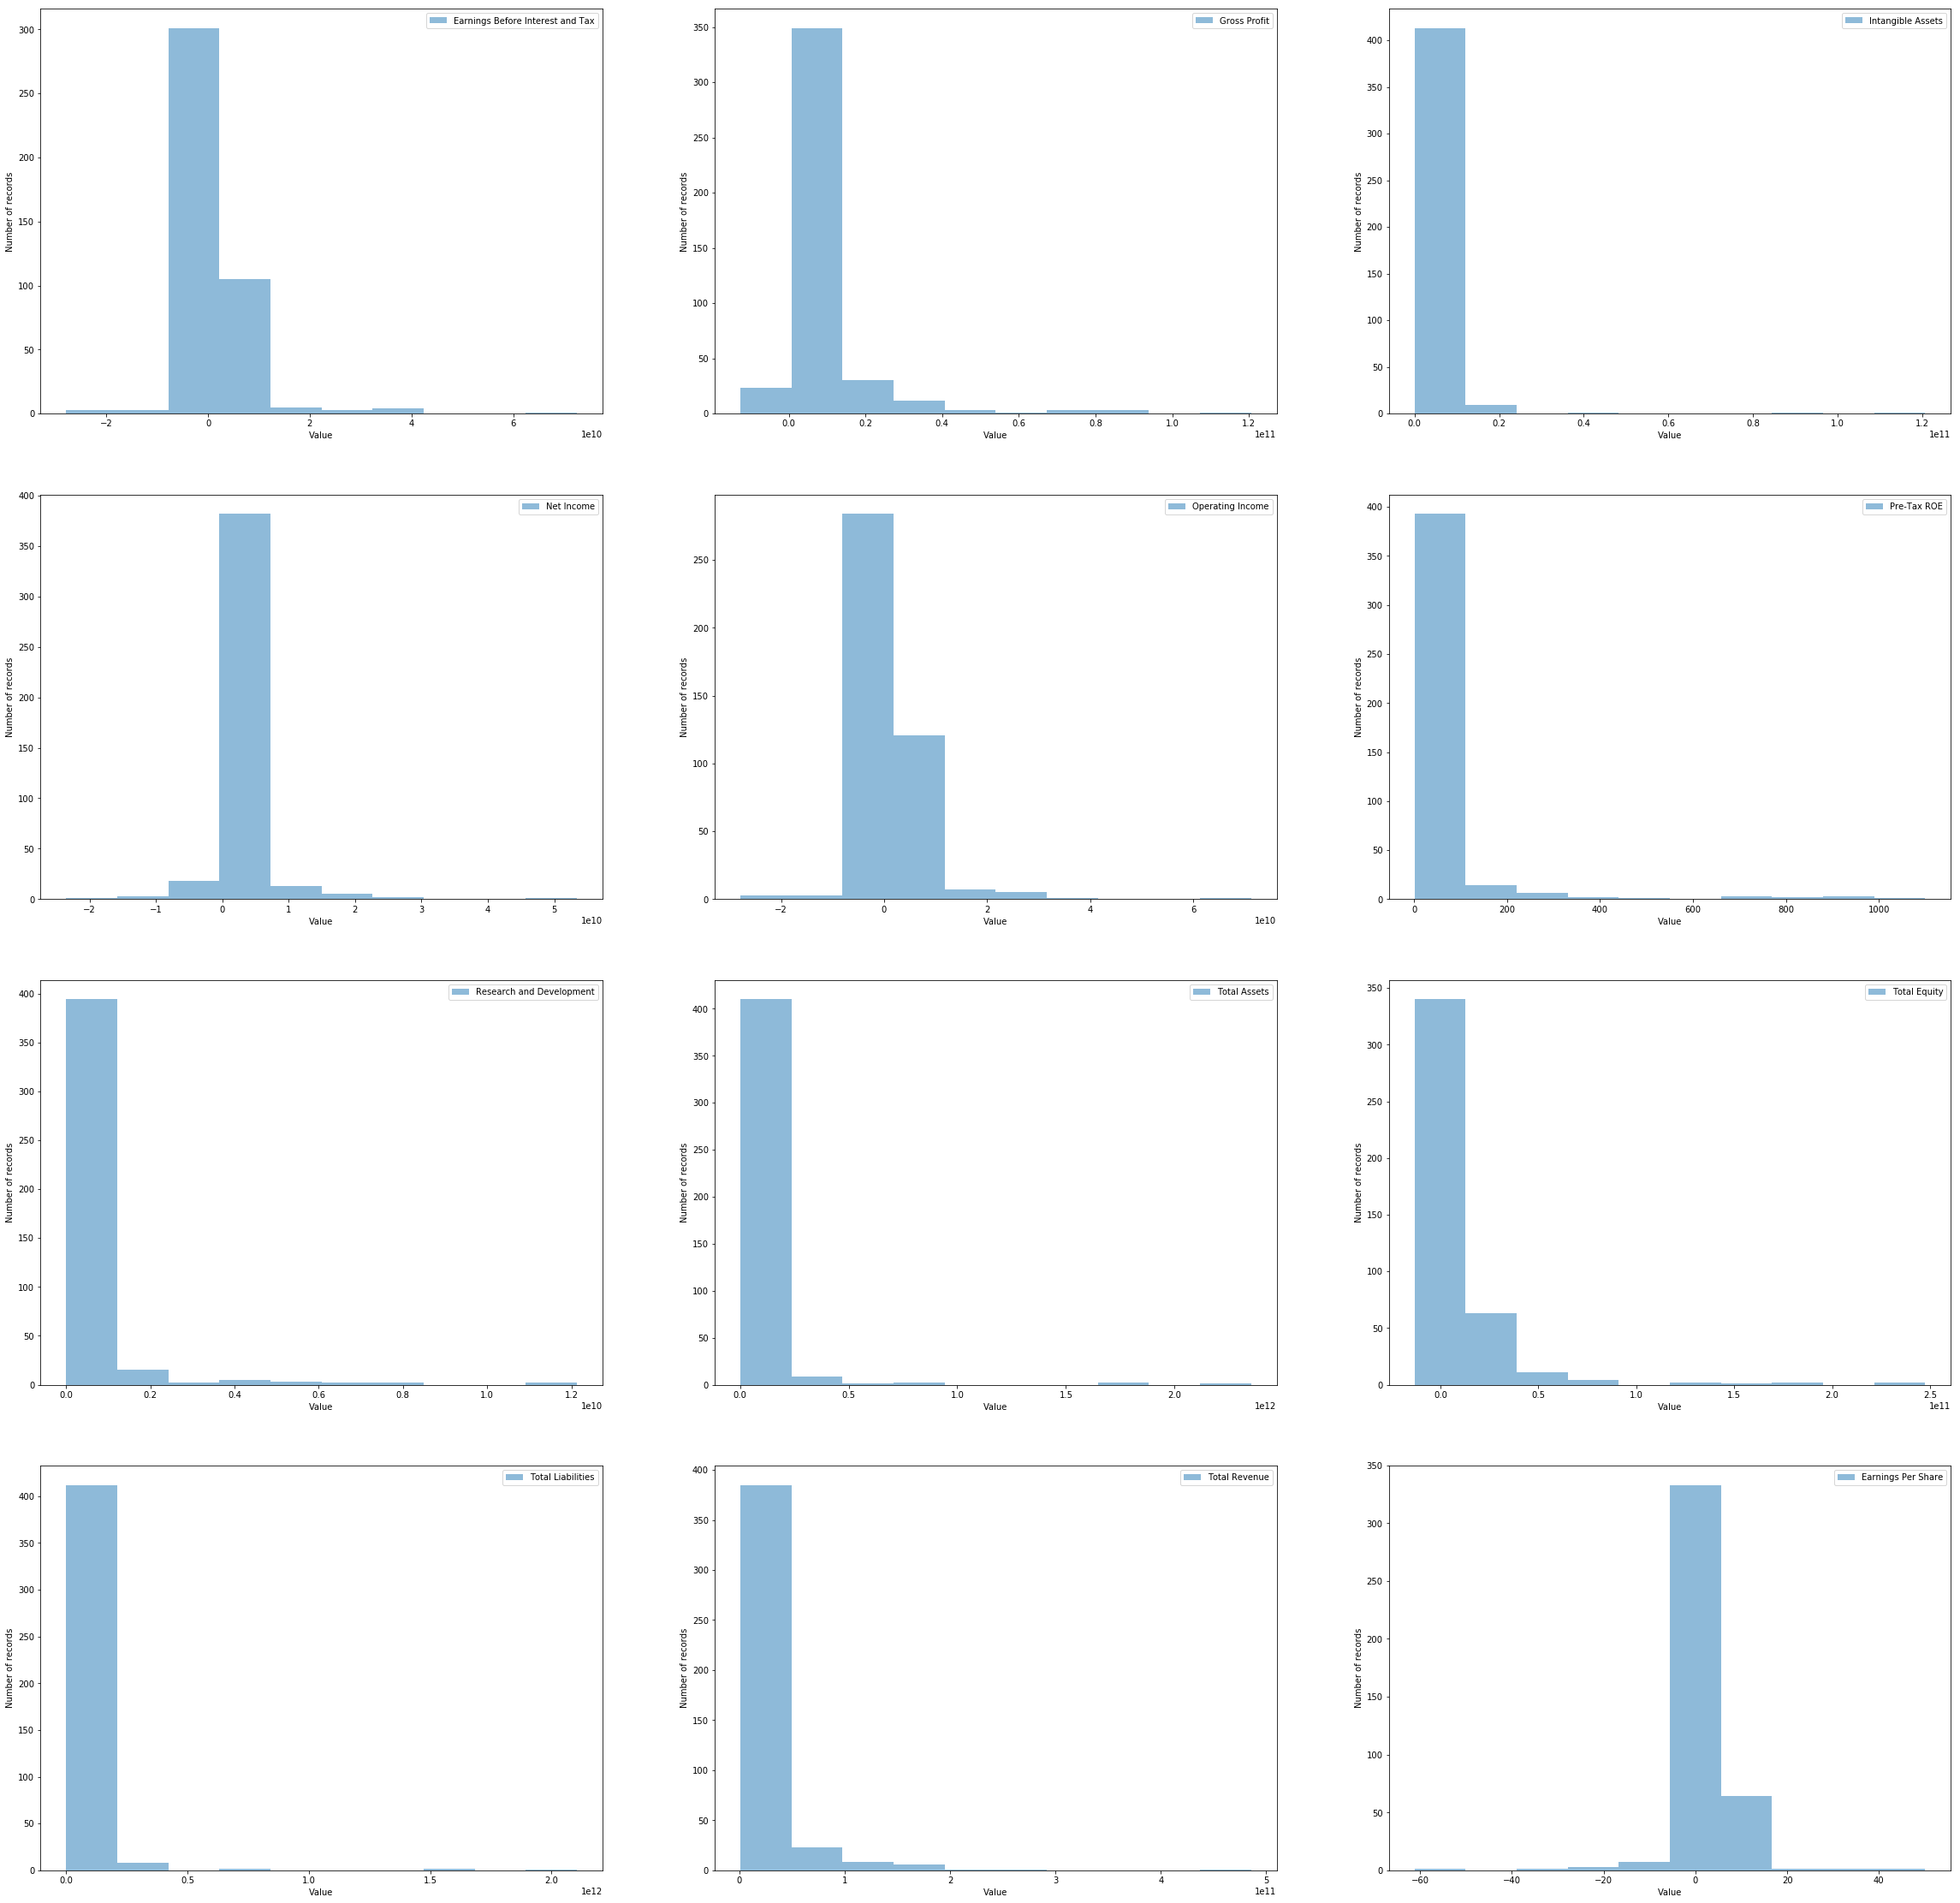

In [251]:
import random

# Get descriptive statistics of features for a random year
years = ['2012', '2013', '2014', '2015', '2016']

# Get a random year to examine
rand_year = random.choice(years)

years_data = fundamental_data.copy().drop('Ticker Symbol', axis = 1)
rand_year_data = years_data[years_data['For Year'] == int(rand_year) ]

print "year: {}".format(rand_year)
display(rand_year_data.describe())

rand_year_data = rand_year_data.drop('For Year', axis = 1)

plt.figure(figsize=(40, 40))

for index, feature in enumerate(rand_year_data):
    plt.subplot(4,3,index + 1)
    rand_year_data[feature].plot.hist(alpha=0.5)
    plt.xlabel('Value')
    plt.ylabel('Number of records')
    plt.legend()

plt.show()


From looking at the histograms, many features were positive-skewed, and I had to transform those values later.  
As for outliers, I thought there were none, because those hight values, some may say call outliers in the features above, could be important charasteristics that decide whether it is a winning stock or not.  

117780    PCLN
Name: symbol, dtype: object
236690    PCLN
Name: symbol, dtype: object
354190    PCLN
Name: symbol, dtype: object
476809    PCLN
Name: symbol, dtype: object
599799    PCLN
Name: symbol, dtype: object
724743    PCLN
Name: symbol, dtype: object
851115    PCLN
Name: symbol, dtype: object


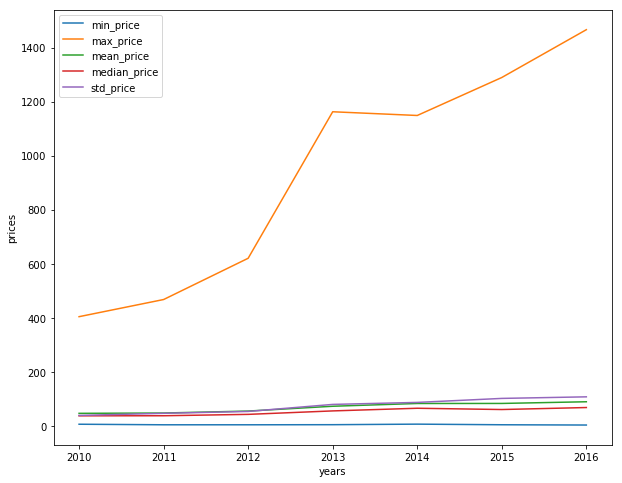

In [3]:
# Get descriptive statistics of labels
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016']

min_prices = []
max_prices = []
mean_prices = []
median_prices = []
std_prices = []

for year in years:

    year_data = price_data.copy()
    year_data = year_data[year_data.date.str.contains(year) == True]
    year_close_data = year_data.close

    min_price = np.amin(year_close_data)
    min_prices.append(min_price)
    
    max_price = np.amax(year_close_data)
    
    # Which company's stock  price is the highest?
    symbol = year_data[year_data.close == max_price].symbol
    print(symbol)
    max_prices.append(max_price)
    
    mean_price = np.mean(year_close_data)
    mean_prices.append(mean_price)
    
    median_price = np.median(year_close_data)
    median_prices.append(median_price)
    
    std_price = np.std(year_close_data)
    std_prices.append(std_price)

plt.figure(num=None, figsize=(10, 8))


plt.plot(years, min_prices, label="min_price")
plt.plot(years, max_prices, label="max_price")
plt.plot(years, mean_prices, label="mean_price")
plt.plot(years, median_prices, label="median_price")
plt.plot(years, std_prices, label="std_price")
plt.xlabel('years')
plt.ylabel('prices')
plt.legend()

plt.show()

Mean, median, are gradually increaseing, which means the value of stock market as a whole is increasing. This could be either caused by some of the big companies that get super high values or a number of small companies increase their values little bit for each.  
The company which has the highest price of stock was Priceline Group Inc(PCLN), and this was the case for all the years. Althought it was interesting that a company keeps the highest price of a stock for several years, I would save it for my future study because this was not super related to the focus of this project.

### Algorithms and Techniques


I make three models and each model uses a different algorithms. Here’re the algorithms to implement with the reasons I chose them.
 
- #### Linear Regression    
  
    - characteristics  
        It’s the most common and basic algorithm when it comes to regression problem.  
        It can be combined with neural network.  
    - how it works  
        It assumes that the data follows a straight line, so it models the relationship between a label and feature, using a linear function. It creates a function that takes features as arguments and calcurete a value, and compare it with a label. Then it measures the difference(error) between the predicted value and the true value. It does this for each data point, and minimize the errors by optimizing the function.  

- #### Decision Tree  
  
    - characteristics  
        It is easy to understand and to interpret how a result is decided.  
        It is robust to change and outliers.  
        It performs well with small amount of data points.  
    - how it works  
        It creates a non-linear regression model between labels and features. The data is split at several split points for each feature. The error between the predicted value and the true values is calculated at each split point. The split point errors across the features are compared and the feature having the lowest error is chosen as the root split point. This process is recursively continued.
   
- #### Deep Neural Network   
  
    - characteristics  
        It is a feedforward network with many hidden layers and modelled on the human brain (neural networks).  
        Even though the logic behind the result it produces is almost impossible to figure out, people say it works well.  
    - how it works  
        Deep neural network is a feedforward network. It has three kinds of layers: input, hidden, and output. The layers are made of nodes. In hideen layers, a node combines a set of inputs from the given data with a set of weights. The sum of input-weight products is passed through a node’s activation function, which decides whether and how much that signal goes further through the network to affect the final outcome. This computation happens at each node in hidden layers, so that it can model a complex non-linear relationship between features and labels. Also, it automatically updates the weights applied to the computation, according to the final outcome.  
   
I use along the following techniques with these algorithms.  
   
- #### Hold-out validation   
It is a technique to see how well a model predict unseen data by splitting an original sample dataset into a training set to train the model, and a test set to evaluate.  
   
- #### Grid Search  
It is a technique to find parameters that perform best for a model. It can work with Cross Validation.  


### Benchmark  

The benchmark is the average growth rate of return in stock market in general. This is because fundamental analysis is not a method but a concept of using fundamentals for evaluating stocks. The method of fundamental analysis varies depending on the person you ask. Therefore, there is no one best way to do that and I used the average returns of stock investment.  
I based it on Standard & Poor's 500 Index, which has been seen as a reflection of the performance of American stocks in general. The data is obtained from this website (http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html). The owner of this website keeps track of CAGR of Standard & Poor's 500 Index for each year.


|Year|	CAGR|
| :-------------: |:-------------:|
|2012|	15.89%|
|2013|	32.15%|	
|2014|	13.52%|	
|2015|	1.38%|	
|2016|	11.74%|

## III. Methodology  

### Data Preprocessing  

I processed the dataset as follows.  
- Removed unnecessary rows  
Feature dataset, which is fundamental data is from 2012 to 2016. Label dataset, which is stock price data is from 2010 to 2016. As you can see,
the duration of the datasets are different. I dropped some of them so that they can match each other.  
- Joined feature dataset and label dataset using (symbol/Ticker Symbol)
If either label or features cannot be found with a Ticker Symbol drop them.
- Normalized features by using sklearn.preprocessing.MinMaxScaler  
This is because the values of the feature dataset are too big to deal with.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# The durating of dataset are gathered from should be the same  
fundamental_data = fundamental_data[fundamental_data['For Year'] != 'missing']
features_to_drop = 2016
fundamental_data = fundamental_data[fundamental_data['For Year'] != features_to_drop]

label_to_drop = ['2010', '2011', '2012']
for year in label_to_drop:
    price_data = price_data[price_data.date.str.contains(year) == False]

# Now, features are from 2012 - 2015 and labes are from 2013 - 2016
# Let's join them
fundamental_data = fundamental_data.set_index('Ticker Symbol')
fundamental_data.index.name = None
price_data = price_data.set_index('symbol')
price_data.index.name = None

joined_data = []

years = [2012, 2013, 2014, 2015]

for year in years:
    year_price_data = price_data.copy()
    year_price_data = year_price_data[year_price_data.date.str.contains(str(year + 1)) == True]
    year_fundamental_data = fundamental_data.copy()
    year_fundamental_data = year_fundamental_data[fundamental_data['For Year'] == (year)]
    joined = year_fundamental_data.join(year_price_data, how='inner')
    joined_data.append(joined)


full_data = pd.concat(joined_data)
# Make sure they are properly joined
print "Joined dataset"
display(full_data.head(n = 1))

# Save 2015 - 2016 year data for model evalation and validation process coming up later
print "Joined dataset for evalation"
data_for_eval = full_data[full_data['For Year'] == 2015]
display(data_for_eval .head(n = 1))

def transform_features(features):
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler()
    numerical = [
        'Earnings Before Interest and Tax',
        'Gross Profit',
        'Intangible Assets',
        'Net Income',
        'Operating Income',
        'Pre-Tax ROE',
        'Research and Development',
        'Total Assets',
        'Total Equity',
        'Total Liabilities',
        'Total Revenue',
        'Earnings Per Share'
    ]

    features[numerical] = scaler.fit_transform(features[numerical])
    return features



labels = full_data.close.to_frame()
features = transform_features(full_data.drop(['close', 'For Year', 'date'], axis=1))

# Show an example of a record with scaling applied
print "Scaled features"
display(features.head(n = 1))

labels_for_eval = data_for_eval.close.to_frame()
features_for_eval = transform_features(data_for_eval.drop(['close', 'For Year', 'date'], axis=1))

# Show an example of a record with scaling applied
print "Scaled features for evalation"
display(features_for_eval.head(n = 1))



Joined dataset


,Earnings Before Interest and Tax,Gross Profit,Intangible Assets,Net Income,Operating Income,Pre-Tax ROE,Research and Development,Total Assets,Total Equity,Total Liabilities,Total Revenue,Earnings Per Share,For Year,date,close
AAL,-1813000000,1.435600e+10,869000000.0,-1876000000,148000000,31,0,2.351000e+10,-7.987000e+09,2.489100e+10,2.485500e+10,-5.6,2012,2013-12-31,25.25


Joined dataset for evalation


,Earnings Before Interest and Tax,Gross Profit,Intangible Assets,Net Income,Operating Income,Pre-Tax ROE,Research and Development,Total Assets,Total Equity,Total Liabilities,Total Revenue,Earnings Per Share,For Year,date,close
AAL,5496000000,2.989400e+10,2.249000e+09,7610000000,6204000000,82,0,4.841500e+10,5.635000e+09,4.278000e+10,4.099000e+10,11.39,2015,2016-12-30,46.689999


Scaled features


,Earnings Before Interest and Tax,Gross Profit,Intangible Assets,Net Income,Operating Income,Pre-Tax ROE,Research and Development,Total Assets,Total Equity,Total Liabilities,Total Revenue,Earnings Per Share
AAL,0.244102,0.166582,0.007199,0.28148,0.283014,0.003411,0.0,0.008738,0.020156,0.010537,0.050378,0.499596


Scaled features for evalation


,Earnings Before Interest and Tax,Gross Profit,Intangible Assets,Net Income,Operating Income,Pre-Tax ROE,Research and Development,Total Assets,Total Equity,Total Liabilities,Total Revenue,Earnings Per Share
AAL,0.332759,0.319348,0.018631,0.4048,0.344099,0.073703,0.0,0.019973,0.072384,0.020189,0.082997,0.65226


### Implementation  
#### Define a Performance Metric  

As I mentioned in Metrics section, I used coefficient of determination to measure the performance of the models.  

In [5]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
     return r2_score(y_true, y_predict)

#### Train and test a model: Decision Tree
Between the three model, I first tried Decision Tree.
As for spliting the dataset into train and test one, I was thinking of using TimeSeriesSplit from sklearn.model_selection. I realized, however, if I just  predict the price of a stock in next year based on corporate fundamentals, I don't need to use it. That's because there is no correlation between observations that are near in time (autocorrelation).

Best performance depth is 21.00
R2 is 0.61


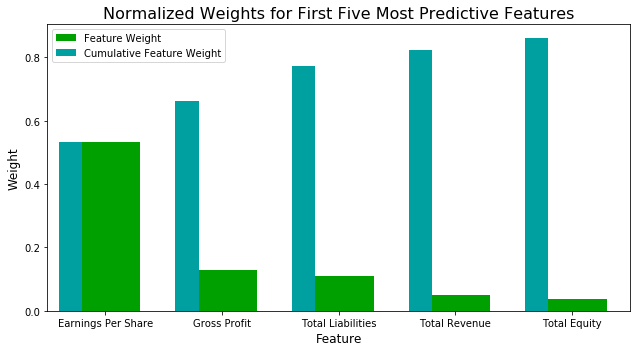

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

def train_predict(X, y):

    random_state = 0

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    
    scores = []
    
    # Experiment with max_depth parameter for the regressor
    for index in range(30):
        depth = index + 1
        regressor = DecisionTreeRegressor(random_state=random_state, max_depth=depth)
        regressor.fit(X_train, y_train)
        prediction = regressor.predict(X_test)
        score = performance_metric(y_test, prediction)
        scores.append(score)
        
    best_performance_depth = np.argmax(scores) + 1
    print "Best performance depth is {0:.2f}".format(best_performance_depth)
    
    regressor = DecisionTreeRegressor(random_state=random_state, max_depth=best_performance_depth)
    regressor.fit(X_train, y_train)
    prediction = regressor.predict(X_test)
    
    score = performance_metric(y_test, prediction)
    print "R2 is {0:.2f}".format(score)


    # Extract the feature importances to see which feature is a more important factor for deciding the price of a stock
    importances = regressor.feature_importances_

    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)

    plt.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()
    
train_predict(features, labels)


As you see the graph above, according to the decision tree model, Earnings Per Share is the most decisive factor of a stock price in next year.  
Many people are probably more comfortable buying the stock of a profitable company. The higher the Earnings Per Share gets, the more people  buy the stock.  
I got curious what would happen if I expand the span; I used two years later stock prices as labels.

,Earnings Before Interest and Tax,Gross Profit,Intangible Assets,Net Income,Operating Income,Pre-Tax ROE,Research and Development,Total Assets,Total Equity,Total Liabilities,Total Revenue,Earnings Per Share,For Year,date,close
AAL,-1813000000,1.435600e+10,869000000.0,-1876000000,148000000,31,0,2.351000e+10,-7.987000e+09,2.489100e+10,2.485500e+10,-5.6,2012,2014-12-31,53.630001


,Earnings Before Interest and Tax,Gross Profit,Intangible Assets,Net Income,Operating Income,Pre-Tax ROE,Research and Development,Total Assets,Total Equity,Total Liabilities,Total Revenue,Earnings Per Share
AAL,0.024524,0.096057,0.010385,0.063757,0.071242,0.003411,0.0,0.008738,0.018126,0.010527,0.051369,0.140159


Best performance depth is 12.00
R2 is 0.53


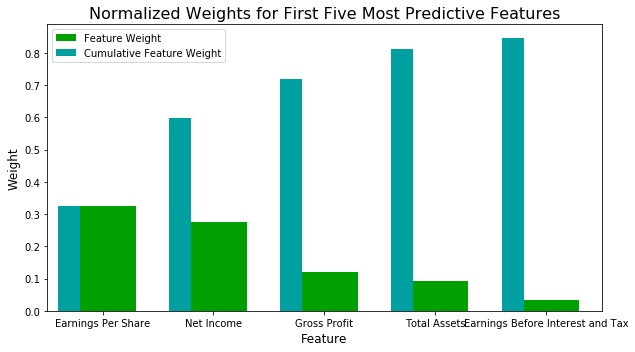

In [7]:
joined_data_two_years = []

for index in range(0, len(years), 2):
    year = years[index]
    year_price_data = price_data.copy()
    year_price_data = year_price_data[year_price_data.date.str.contains(str(year + 2)) == True]
    year_fundamental_data = fundamental_data.copy()
    year_fundamental_data = year_fundamental_data[fundamental_data['For Year'] == (year)]
    joined = year_fundamental_data.join(year_price_data, how='inner')
    joined_data_two_years.append(joined)
    
full_data_two_years = pd.concat(joined_data_two_years)

# Make sure they are properly joined
display(full_data_two_years.head(n = 1))

labels_two_years = full_data_two_years.close
features_two_years = full_data_two_years.drop(['close', 'For Year', 'date'], axis=1)

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = [
    'Earnings Before Interest and Tax',
    'Gross Profit',
    'Intangible Assets',
    'Net Income',
    'Operating Income',
    'Pre-Tax ROE',
    'Research and Development',
    'Total Assets',
    'Total Equity',
    'Total Liabilities',
    'Total Revenue',
    'Earnings Per Share'
]

features_two_years[numerical] = scaler.fit_transform(features_two_years[numerical])

# Show an example of a record with scaling applied
display(features_two_years.head(n = 1))

# Feed the regressor with the dataset
train_predict(features_two_years, labels_two_years)


The r-squared score wend down by about 1%. This simply means it is harder to predict the price of a stock in the long run.  
Also Net Income come in next to Earnings Per Share's weight, which made me think people prefer to buying even bigger and more profitable company's stock in two years.

#### Train and test a model: Linear Regression  
Next I tried Linear Regression. I experimented with steps parameter which tells tensorflow to run iterations to train a model. The r-squared score was negative even when 10,000 steps(iterations) applied and from the graph of 'how r-squared score changes', I didn't think it would get better even if I increased the steps.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1129aaa10>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving

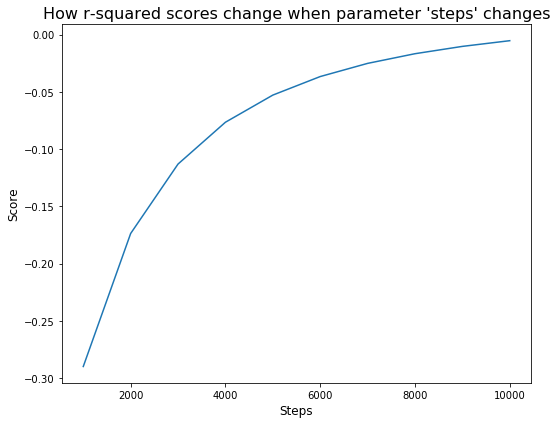

In [8]:
import tensorflow as tf

def input_fn(X, y):
    features = {k: tf.constant(X[k].values) for k in X.columns.values.tolist()}
    labels = tf.constant(y.close.values)
    return features, labels

def test_input_fn(X):
    return {k: tf.constant(X[k].values) for k in X.columns.values.tolist()}, None

def linear_train_predict(X, y, steps):
    
    random_state = 0
    # I needed to replace space with underscore to make Tensorflow constructor work. 
    X.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    feature_cols = [tf.contrib.layers.real_valued_column(k) for k in X.columns.values.tolist()]
    
    regressor = tf.contrib.learn.LinearRegressor(feature_columns=feature_cols)
    regressor.fit(input_fn=lambda: input_fn(X_train, y_train), steps=steps)
    prediction = regressor.predict_scores(input_fn=lambda: test_input_fn(X_test), as_iterable=False)
    score = performance_metric(y_test, prediction)
    print "R2 is {0:.2f} when parameter steps is {0}".format(score)
    return score

scoresArray = []
stepsArray = []
for steps in range(1000, 10001, 1000):
    score = linear_train_predict(features, labels, steps)
    scoresArray.append(score)
    stepsArray.append(steps)

plt.figure(num=None, figsize=(8, 6))
plt.title("How r-squared score changes when parameter 'steps' changes", fontsize = 16)
plt.plot(stepsArray, scoresArray)
plt.ylabel("Score", fontsize = 12)
plt.xlabel("Steps", fontsize = 12)
plt.tight_layout()
plt.show()



#### Train and test a model: Deep Neural Network
Finally, I tried Deep Neural Network.  The type of deep neural network I tried was called DNNRegressor. As the name implies, it construct a neural network regressions model. It takes a set of features and output the predictions. Then compare them to the labels(true value) to measure the error and tries to minimize it by updating the weights applied to inputs in hidden layers. This process is repeated to get a better result. 
  
After more than 12 hours of the model being learning in my laptop, the r-squred score was only 0.14.  I could've kept going, but I didn't because I couldn't imagine how much time would be required to get to a similar result to the one achieved by Decision Tree Regressor.

In [15]:
def dnn_train_predict(X, y):
    
    random_state = 0
    # I needed to replace space with underscore to make Tensorflow constructor work. 
    X.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    feature_cols = [tf.contrib.layers.real_valued_column(k) for k in X.columns.values.tolist()]
    regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, hidden_units=[64, 32], model_dir='.log')
    regressor.fit(input_fn=lambda: input_fn(X_train, y_train), max_steps=7000000)
    prediction = regressor.predict_scores(input_fn=lambda: test_input_fn(X_test), as_iterable=False)
    score = performance_metric(y_test, prediction)
    print "R2 is {0:.2f}".format(score)
    return score

dnn_train_predict(features, labels)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x118b29bd0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restor

0.13871735187269252

### Refinement  
Between the models, in terms of the scores, and the learning time of the models, I decided to pick the decision tree regressor as the best one and to improve the score by optimizing parameters for the regressor with the grid search technique.  
  
The grid search exhaustively generated candidates from a grid of parameter values that I gave as follows.  
  
- max depth: The maximum depth of the tree  
    It controls the size of the tree to prevent overfitting.
- max_features: The number of features to consider when looking for the best split  
    If you increase it, it usually improves the performance of the model, however you might end up decreasing the speed of algorithm by doing so.  
- min_samples_split: The minimum number of samples required to split an internal node  
    If it is a small number, the tree tends to overfit, wheres if it's a large number, it will prevent the tree from learning the data  
  
As a result, it picked parameters: max_depth=35, min_samples_split=4, max_features=None, and r-squared score improved from 0.61 to 0.86.

In [73]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def refined_dt_train_predict(X, y):

    random_state = 0

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    params = {'max_depth': [i for i in range(1, 100)], 'min_samples_split':  [i for i in range(2, 10)], 'max_features':  [None, 'sqrt', 'log2']}
    scoring_fnc = make_scorer(performance_metric)

    grid = GridSearchCV(DecisionTreeRegressor(), params, scoring=scoring_fnc, n_jobs=4)
    grid.fit(X_train, y_train)
    
    prediction = grid.predict(X_test)
    
    score = performance_metric(y_test, prediction)
    print "R2 is {0:.2f}".format(score)
    
    return best_reg
    
best_reg = refined_dt_train_predict(features, labels)
print best_reg

R2 is 0.86
DecisionTreeRegressor(criterion='mse', max_depth=35, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')


## IV. Results  

### Model Evaluation and Validation  
The best performance parameters  
- max_depth: 35  
- min_samples_split: 4  
- max_features: None  
- r-squared score: 0.86  
  
I picked the decision tree model with the parameters above as best because it's easy to see the logic of the model because it shows you what features are considered important. This is beneficial as fundamental analysis have been studied and practiced among investors, so it's easy to justify the logic.  
As I mentioned earlier, there are three step I went through to evaluate the model.  
1. I had the best model predict prices of all the stocks in one year that the model had never seen (I saved 2015 - 2016 year data for this evalation)  
2. I calculated the CAGR of 30 stocks that would get the highest growth in price, using the sum of original price of stocks as the beginning value and the sum of the next year price as the ending value. These next year prices are not the ones predicted by the model, but are the actual prices of the following year.  
3. I compared the result to the CAGR of return on the market.

In [224]:
# Step 1-a Let the model predict the prices
# The predicted prices are for 2016/12/31 based on 2015's fundamentals of the companies.
predicted_prices = {features_for_eval.index[i]: price for i, price in enumerate(best_reg.predict(features_for_eval))}

# Step 1-b I have to know the growth rate so get the prices on 2015/12/31
one_year_before = full_data[full_data['For Year'] == 2014]
one_year_before_prices = { one_year_before.index[i]: price for i, price in enumerate(one_year_before.close)}

"""
I discovered that the number of the stocks in 2015 and the number of the stocks in 2014 didn't match.
That's because some might've gone bankrupt and got removed from the market or others might've joined the market from 2015.
So filter the companies with symbols.
""" 

filtered_data = []
for (symbol, price) in predicted_prices.iteritems():
    if symbol in one_year_before_prices:
        filtered_data.append({
            'symbol': symbol,
            'before': one_year_before_prices[symbol],
            'predicted': price,
            'growth rate': float(price / one_year_before_prices[symbol])
        })

# Step 2 select 30 stocks having the highest growth rate and calclated CAGR

def select_growing_stocks(num) :        
    growing_stocks = []
    qualified = False
    for data in filtered_data:
        if len(growing_stocks) < num:
            qualified = True
        elif growing_stocks[-1]['growth rate'] < data['growth rate']:
            growing_stocks.pop()
            qualified = True
        if qualified:
            growing_stocks.append(data)
            growing_stocks.sort(key=lambda x:x['growth rate'], reverse=True)
            qualified = False
    return growing_stocks

# Calclate CAGR of the 30 stocks
# CAGR = ((Ending Value / Beginning Value) ^ (1 / number of years)) - 1

def calculate_cagr(growing_stocks):

    # I need to know the actual stock prices on 2016/12/31 before calculating CAGR
    actual_prices = {labels_for_eval.index[i]: price for i, price in enumerate(labels_for_eval.close)}
    for data in growing_stocks:
        data['after'] = actual_prices[data['symbol']]

    beginning_value = np.sum([data['before'] for data in growing_stocks])
    ending_value = np.sum([data['after'] for data in growing_stocks])
    cagr = ((ending_value / beginning_value) ** (1/1)) - 1
    print "The CAGR of the {1} stocks is {0:.2f} ({0:.2%}) ".format(cagr, len(growing_stocks))
    return cagr

calculate_cagr(select_growing_stocks(30))

# step 3 compared the CAGR to the entire market's CAGR
#  market's CAGR is 1.174 which is11.74%

The CAGR of the 30 stocks is 0.23 (22.85%) 


0.22853879663319132

#### Compare the CAGR to the entire market's CAGR of 2016
|  30 stocks        | Market           | Diff  |
| :-------------: |:-------------:| :-----:|
| 22.85%     | 11.74% | + 11.11 % |

### Justification  
As you see, the growth of the stocks picked by the model surpassed the growth of the market.  
To justify the result, I looked at the features considered as important by this model.

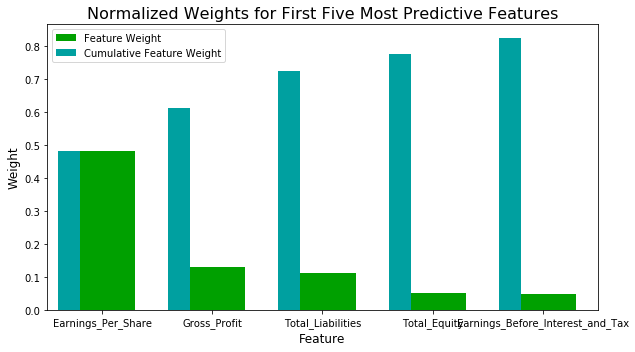

In [194]:
# Extract the feature importances to see which feature is a more important factor for deciding the price of a stock
importances = best_reg.feature_importances_

indices = np.argsort(importances)[::-1]
columns = features.columns.values[indices[:5]]
values = importances[indices][:5]

# Creat the plot
fig = plt.figure(figsize = (9,5))
plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', label = "Feature Weight")
plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', label = "Cumulative Feature Weight")
plt.xticks(np.arange(5), columns)
plt.xlim((-0.5, 4.5))
plt.ylabel("Weight", fontsize = 12)
plt.xlabel("Feature", fontsize = 12)

plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

From the graph above, Earnings Per Share is considered the most important by this model.  
This makes sense from a perspective of investors. Investopedia, which is the world's leading source of financial/stock market content on the web, say the following about Earnings Per Share.  
> Earnings per share is generally considered to be the single most important variable in determining a share's price. It is also a major component used to calculate the price-to-earnings valuation ratio.  
  
The quote obtained from this page: http://www.investopedia.com/terms/e/eps.asp

## V. Conclusion  

### Free-Form Visualization

I wondered how many stocks are appropriate amount to buy, so I calculated CAGR of when the number of stocks is x with x being from 1 to 50.

The CAGR of the 1 stocks is 0.60 (59.55%) 
The CAGR of the 2 stocks is 0.45 (44.99%) 
The CAGR of the 3 stocks is 0.18 (18.12%) 
The CAGR of the 4 stocks is 0.26 (26.00%) 
The CAGR of the 5 stocks is 0.29 (28.51%) 
The CAGR of the 6 stocks is 0.41 (41.18%) 
The CAGR of the 7 stocks is 0.29 (29.07%) 
The CAGR of the 8 stocks is 0.26 (26.42%) 
The CAGR of the 9 stocks is 0.23 (22.59%) 
The CAGR of the 10 stocks is 0.25 (24.77%) 
The CAGR of the 11 stocks is 0.35 (34.77%) 
The CAGR of the 12 stocks is 0.27 (27.24%) 
The CAGR of the 13 stocks is 0.28 (28.37%) 
The CAGR of the 14 stocks is 0.23 (23.32%) 
The CAGR of the 15 stocks is 0.22 (22.05%) 
The CAGR of the 16 stocks is 0.21 (21.04%) 
The CAGR of the 17 stocks is 0.21 (21.15%) 
The CAGR of the 18 stocks is 0.21 (20.75%) 
The CAGR of the 19 stocks is 0.18 (18.36%) 
The CAGR of the 20 stocks is 0.19 (19.19%) 
The CAGR of the 21 stocks is 0.30 (30.02%) 
The CAGR of the 22 stocks is 0.28 (27.76%) 
The CAGR of the 23 stocks is 0.28 (27.75%

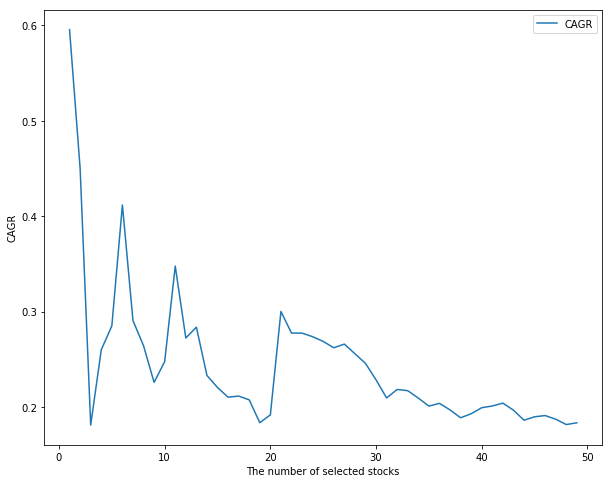

In [237]:
data = {i : calculate_cagr(select_growing_stocks(i)) for i in xrange(1, 50)}
print "The average of CAGR is {0:.2f}({0:%})".format(np.mean(data.values()))
plt.figure(num=None, figsize=(10, 8))
plt.plot(data.keys(), data.values(), label="CAGR")
plt.xlabel('The number of selected stocks')
plt.ylabel('CAGR')
plt.legend()

plt.show()

As you see, the more stocks you buy, the less volatile CAGR becomes.  
It is a common wisdom among investors that having more than 20 - 30 stocks at a time makes your portfolio more balanced.  
This wisdom has been proven true here too.

### Reflection

The most difficult challenge I faced in this project was processing the datasets.  
The datasets are taken from Kaggle but to make it usable for this project, I had to do the following things.  
  
- Refining the datasets  
There were two datasets: one was a dataset of corporate fundamentals, and the other was a dataset of stock prices. Some companies were listed in the both datasets, but others were only in one dataset. I had to remove the latter.    
  
- Associating the datasets  
I had to associate corporate fundamentals of a year and stock prices of the following year.  

- Filtering the dataset  
While I was on Model Evaluation and Validation process, I discovered that the number of the　stocks in 2015 and the number of the stocks in 2014 didn't match.  That's because some might've gone bankrupt and got removed from the market or others might've joined the market from 2015.  So I had to filter the companies with symbols.  
  
This challenge gave me an opportunity to get more familiar with numpy, pandas, and matlab and taught me how important to be aware of what kind of data you deal with before you get started and stay careful of them during a project.  

One last thing I wanted to mention was whether I would use this model or not.  
The answer was no, because it didn't take brokers' fees into account and inflation was not adjusted at all.  

### Improvement

Next time, I would implement ensemble method and RandomForestRegressor algorithm in order to improve generalizability or robustness.  
Also, I would save more datasets for evaluation process, so that I can test the performance of a model more thoroughly with those unseen datasets. Also, if I do that, the amount of dataset I can use to feed a model would be small, so I would use k-fold cross-validation training technique, which makes it possible for a model to learn better when the amount of dataset is small.  